In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from polygon import RESTClient
import yfinance as yf
import requests

import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm
import os
import time

pd.options.mode.chained_assignment = None

In [2]:
start='1999-01-01'
end='2025-03-20'
directory='data/prices_1_day'
ext_dir = 'data/external'

## S&P500 Historical components

In [3]:
# Dateranges in S&P500 list for each ticker
hc = pd.read_csv(f'{ext_dir}/sp500_ticker_start_end.csv')
hc

,ticker,start_date,end_date
0,A,2000-06-05,NaN
1,AABA,1999-12-08,2017-06-19
2,AAL,1996-01-02,1997-01-15
3,AAL,2015-03-23,2024-09-23
4,AAMRQ,1996-01-02,2003-03-14
...,...,...,...
1219,YUM,1997-10-07,NaN
1220,ZBH,2001-08-07,NaN
1221,ZBRA,2019-12-23,NaN
1222,ZION,2001-06-25,2024-03-18


In [4]:
# Example of Stocks presented in SP500 more than once.

counts = hc.groupby(by=['ticker'])['start_date'].count().reset_index()
counts[counts['start_date']>1].head()

,ticker,start_date
2,AAL,2
57,AMD,2
62,AMP,2
66,AN,2
164,BR,2


## Data Collection Process

In [5]:
def history(ticker:str, start:str, end:str)->pd.DataFrame:
    data = yf.Ticker(ticker).history(start=start, end=end, auto_adjust=False).reset_index()
    data['Date'] = pd.to_datetime(data['Date']).dt.date.astype(str)
    data['Ticker'] = ticker
    return data

def check_sp500_listing(batch:pd.DataFrame)->pd.DataFrame:
    sp500_periods = hc[hc['ticker']=='AMD'].fillna(datetime.now().strftime('%Y-%m-%d'))
    periods = tuple(zip(sp500_periods['start_date'], sp500_periods['end_date']))
    batch['in_sp500'] = False 
    for p in periods:
        batch['after_sd'] = batch['Date'] > p[0]
        batch['before_ed'] = batch['Date'] < p[1]
        batch['in_sp500'] = batch['in_sp500'] + (batch['after_sd'] * batch['before_ed'])

    batch['in_sp500'] = batch['in_sp500'].astype(int)
    return batch

def technical_indicators(data:pd.DataFrame)->pd.DataFrame:

    def sma(df, column, intervals):
        '''
        SMA - Simple Moving Average
        '''
        
        for i in intervals:
            df[f'{column}_SMA_{i}'] = df[column].rolling(window=i).mean()
        return df

    def ema(df, column, intervals):
        '''
        EMA - Exponential Moving Average
        '''
                
        for i in intervals:
            df[f'{column}_EMA_{i}'] = df[column].ewm(span=i, adjust=False).mean()
        return df
    
    def rsi(df, column):
        '''
        RSI - Relative Strength Index
        '''
        delta = df[column].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        for i in [7, 14]:
    
            avg_gain = gain.rolling(window=i).mean()
            avg_loss = loss.rolling(window=i).mean()
        
            for j in range(i, len(df)):
                avg_gain.iloc[j] = (avg_gain.iloc[j-1] * (i-1) + gain.iloc[j]) / i
                avg_loss.iloc[j] = (avg_loss.iloc[j-1] * (i-1) + loss.iloc[j]) / i
            
            rs = avg_gain / avg_loss
            df[f'RSI_{i}'] = 100 - (100 / (1 + rs))
        return df
    
    def bb(df, column):
        '''
        Bollinger Bands (Upper and lower Bands)
        '''
        std_dev = df[column].rolling(window=20).std()
        df[f'{column}_SMA_20'] = df[column].rolling(window=20).mean()
        df['BB_U_Band'] = df[f'{column}_SMA_20'] + (2 * std_dev)
        df['BB_L_Band'] = df[f'{column}_SMA_20'] - (2 * std_dev)
        return df
    
    def macd(df, column):
        df = ema(df, column, [12, 26])
        df['MACD'] = df[f'{column}_EMA_12'] - df[f'{column}_EMA_26']
        df = ema(df, 'MACD', [9])
        df['Signal'] = df['MACD_EMA_9'].values
        df['Histogram'] = df['MACD'] - df['Signal']
        df = df.drop(columns=[f'{column}_EMA_12', f'{column}_EMA_26', 'MACD_EMA_9'])
        return df

    data = sma(data, 'Close', [7, 50, 200])
    data = sma(data, 'Volume', [7, 50, 200])
    data = ema(data, 'Close', [7, 50, 200])
    data = rsi(data, 'Close')
    data = bb(data, 'Close')
    data = macd(data, 'Close')

    return data

def get_ticker_events(tickers:list):

    '''
    Collects all events for each ticker (ticker - raname)
    '''

    file = f'{ext_dir}/tikers_events.csv'
    if os.path.isfile(file):
        return pd.read_csv(file)

    api_key = os.environ['PTOKEN']
    frames = []
    for ticker in tqdm(tickers):
        url = f"https://api.polygon.io/vX/reference/tickers/{ticker}/events?apiKey={api_key}"

        response = requests.get(url)
        if response.status_code != 200:
            continue

        delistings_data = response.json()

        delistings_df = pd.DataFrame(delistings_data['results'])
        events = pd.DataFrame.from_records(delistings_df['events'])
        events = events[events['type'] == 'ticker_change'][['date']]
        events['Ticker'] = ticker
        if len(events)>1:
            frames.append(events.sort_values(by=['date'], ascending=False).head(1))
        time.sleep(0.5)
    
    df = pd.concat(frames, ignore_index=True)
    df['ticker_name_change'] = 1
    df.to_csv(file, index=False)
    return df

for ticker in tqdm(hc['ticker'].unique().tolist() + ['SPY']):
    try:
        batch = yf.Ticker(ticker).history(start=start, end=end, auto_adjust=False).reset_index()
        batch['Date'] = pd.to_datetime(batch['Date']).dt.date.astype(str)
        batch['Ticker'] = ticker

        batch = check_sp500_listing(batch)

        batch['in_sp500'] = batch['in_sp500'].astype(int)
        columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'in_sp500']
        batch = batch[[col for col in columns if col in batch.columns]]
        # batch = technical_indicators(batch)
        batch = batch[batch['Date'] > '2000-01-01'].reset_index(drop=True)
        batch.to_csv(f'{directory}/{ticker}_daily_stock_prices.csv', index=False)

        time.sleep(0.5)
    except:
        continue


100%|██████████| 1176/1176 [18:19<00:00,  1.07it/s]


## Show SPY Indicators

In [ ]:
def plot_indicators(df):
    plt.style.use('ggplot')
    
    ticker_symbol = df['Ticker'].values[0]
    # Создаем подграфики
    fig, axs = plt.subplots(7, 1, figsize=(14, 24), gridspec_kw={'height_ratios': [3, 3, 1, 1, 2, 2, 3]})
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    # SMA Plot
    axs[0].plot(df['Date'], df['Close'], label='Close Price', alpha=0.7)
    axs[0].plot(df['Date'], df['Close_SMA_7'], label='SMA 7', linestyle='--')
    axs[0].plot(df['Date'], df['Close_SMA_20'], label='SMA 20', linestyle='--')
    axs[0].plot(df['Date'], df['Close_SMA_50'], label='SMA 50', linestyle='--')
    axs[0].plot(df['Date'], df['Close_SMA_200'], label='SMA 200', linestyle='--')
    axs[0].set_title(f'{ticker_symbol} - Price and Moving Averages')
    axs[0].legend()

    # EMA Plot
    axs[1].plot(df['Date'], df['Close'], label='Close Price', alpha=0.7)
    axs[1].plot(df['Date'], df['Close_EMA_7'], label='EMA 7', linestyle='--')
    axs[1].plot(df['Date'], df['Close_EMA_50'], label='EMA 50', linestyle='--')
    axs[1].plot(df['Date'], df['Close_EMA_200'], label='EMA 200', linestyle='--')
    axs[1].set_title(f'{ticker_symbol} - Price and Exp. Moving Averages')
    axs[1].legend()
    
    # RSI(7) Plots
    axs[2].plot(df['Date'], df['RSI_7'], color='purple', alpha=0.7)
    axs[2].axhline(y=70, color='r', linestyle='--', alpha=0.5)
    axs[2].axhline(y=30, color='g', linestyle='--', alpha=0.5)
    axs[2].fill_between(df['Date'], df['RSI_7'], 70, where=df['RSI_7'] > 70, color='r', alpha=0.3)
    axs[2].fill_between(df['Date'], df['RSI_7'], 30, where=df['RSI_7'] < 30, color='g', alpha=0.3)
    axs[2].set_title(f'{ticker_symbol} - RSI (7)')
    axs[2].set_ylim(0, 100)

    # RSI(14) Plot
    axs[3].plot(df['Date'], df['RSI_14'], color='purple', alpha=0.7)
    axs[3].axhline(y=70, color='r', linestyle='--', alpha=0.5)
    axs[3].axhline(y=30, color='g', linestyle='--', alpha=0.5)
    axs[3].fill_between(df['Date'], df['RSI_14'], 70, where=df['RSI_14'] > 70, color='r', alpha=0.3)
    axs[3].fill_between(df['Date'], df['RSI_14'], 30, where=df['RSI_14'] < 30, color='g', alpha=0.3)
    axs[3].set_title(f'{ticker_symbol} - RSI (14)')
    axs[3].set_ylim(0, 100)


    # Bollinger Bands Plot
    axs[4].plot(df['Date'], df['Close'], label='Close Price', alpha=0.7)
    axs[4].plot(df['Date'], df['BB_U_Band'], label='Upper Band', linestyle='--', alpha=0.7)
    axs[4].plot(df['Date'], df['BB_L_Band'], label='Lower Band', linestyle='--', alpha=0.7)
    axs[4].fill_between(df['Date'], df['BB_U_Band'], df['BB_L_Band'], alpha=0.1)
    axs[4].set_title(f'{ticker_symbol} - Bollinger Bands')
    axs[4].legend()

    # MACD
    axs[5].plot(df['Date'], df['MACD'], label='MACD', color='purple')
    axs[5].plot(df['Date'], df['Signal'], label='Signal line', color='orange', linestyle='dashed')
    axs[5].bar(df['Date'], df['Histogram'], label='Hist', color=['green' if val >= 0 else 'red' for val in df['Histogram']])
    axs[5].set_title(f'{ticker_symbol} - MACD')
    axs[5].legend()

    # Volume SMA Plot
    axs[6].plot(df['Date'], df['Volume'], label='Volume', alpha=0.7)
    axs[6].plot(df['Date'], df['Volume_SMA_7'], label='SMA 7', linestyle='--')
    axs[6].plot(df['Date'], df['Volume_SMA_50'], label='SMA 50', linestyle='--')
    axs[6].plot(df['Date'], df['Volume_SMA_200'], label='SMA 200', linestyle='--')
    axs[6].set_title(f'{ticker_symbol} - Volume and Moving Averages')
    axs[6].legend()

    # plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

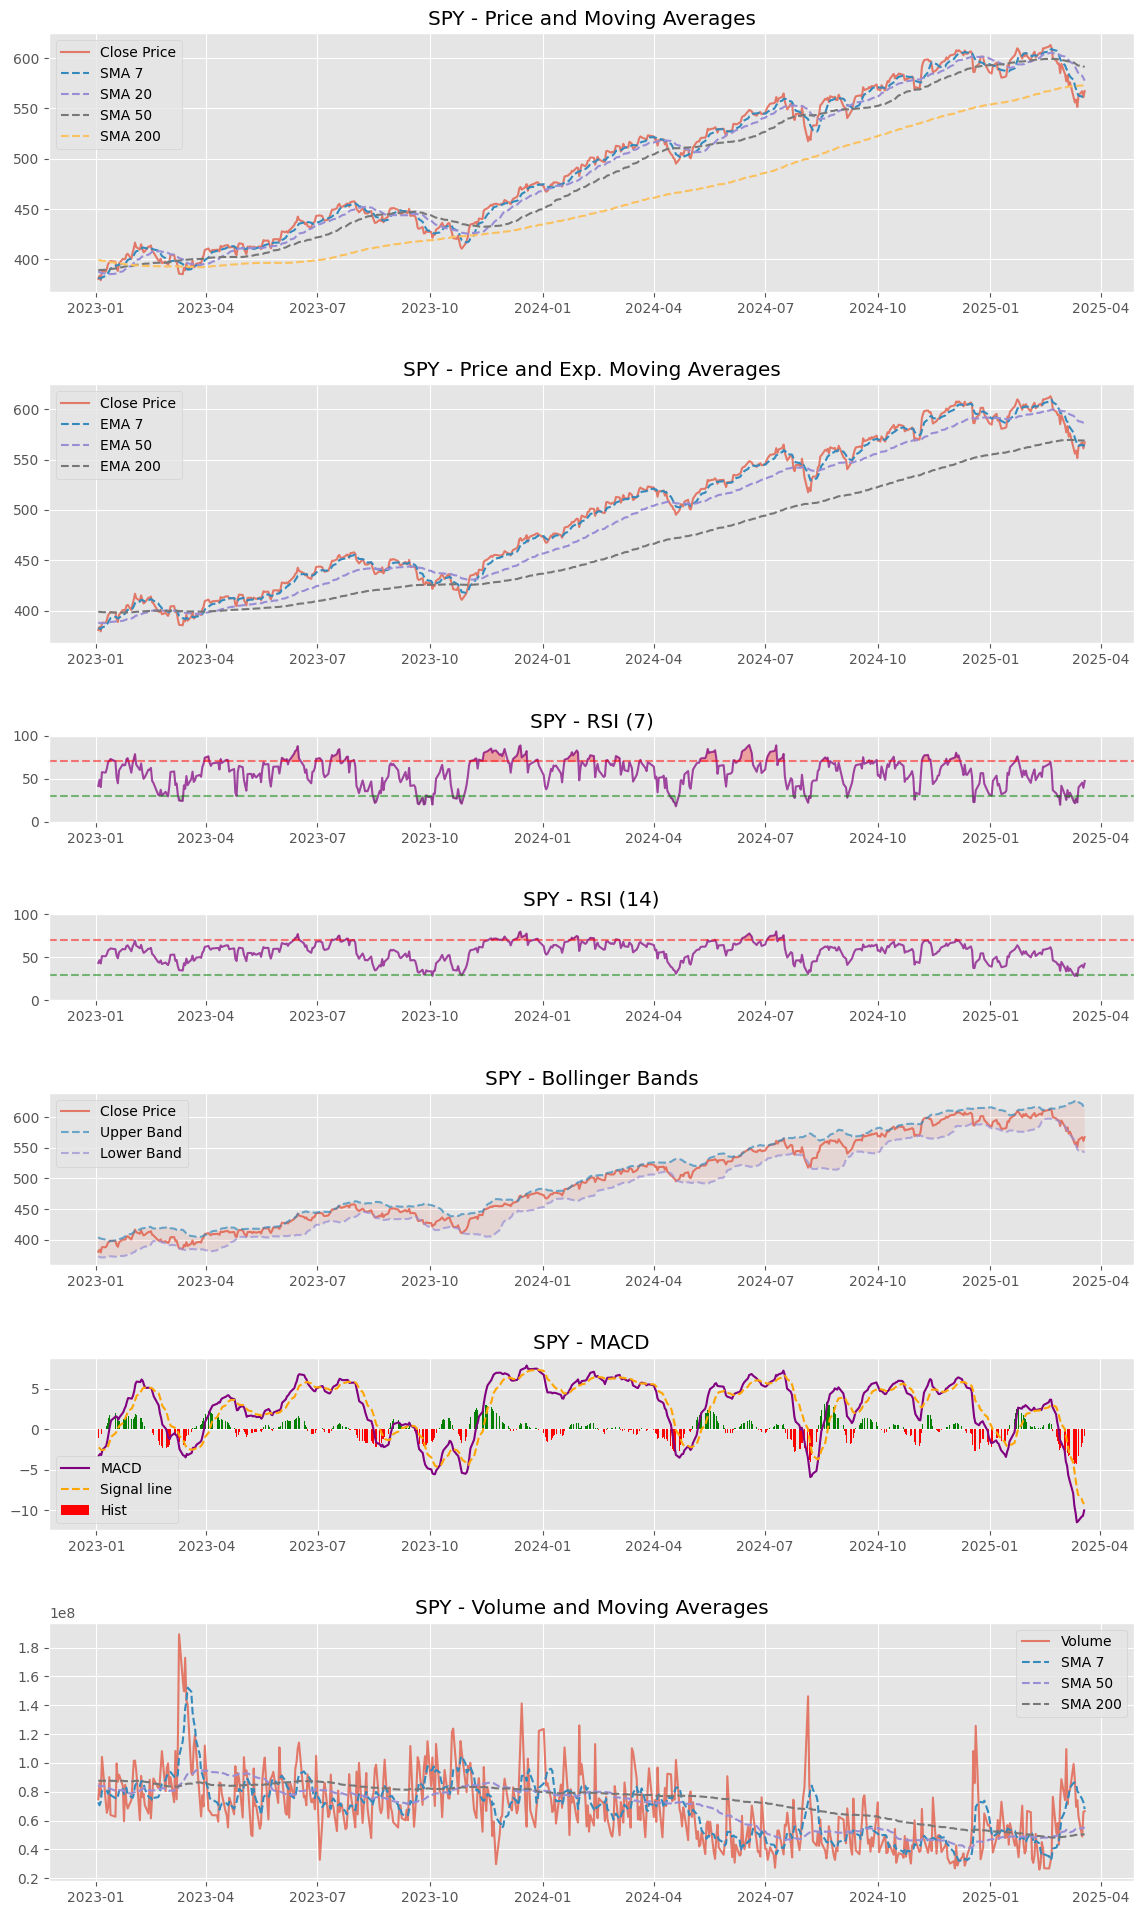

In [ ]:
plot_indicators(batch[batch['Date'] > '2023-01-01'])

In [89]:
batch.columns

Index(['Date', 'Ticker', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'in_sp500', 'Close_SMA_7', 'Close_SMA_50', 'Close_SMA_200',
       'Volume_SMA_7', 'Volume_SMA_50', 'Volume_SMA_200', 'Close_EMA_7',
       'Close_EMA_50', 'Close_EMA_200', 'RSI_7', 'RSI_14', 'Close_SMA_20',
       'BB_U_Band', 'BB_L_Band', 'MACD', 'Signal', 'Histogram'],
      dtype='object')

## SPY Dataset

In [84]:
def build_one_df(directory:str, core_ticker:str):

    def get_events(frame):
        frame['delisting'] = frame['in_sp500'].diff()
        delistings = frame[(frame['delisting']!=0) & (frame['in_sp500']==0)][['Date']]
        delistings['delistings'] = 1
        listings = frame[(frame['delisting']!=0) & (frame['in_sp500']==1)][['Date']]
        listings['listings'] = 1
        splits = frame[frame['Stock Splits']!=0][['Date']]
        splits['splits']=1
        return delistings, listings, splits

    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    df_list = [pd.read_csv(os.path.join(directory, file)) for file in tqdm(csv_files)]

    spy_frame = pd.read_csv(os.path.join(directory,[_ for _ in csv_files if core_ticker in _][0]))
    top_spy_holdings = ['AAPL', 'NVDA', 'MSFT', 'AMZN', 'META', 'BRK-B', 'BRK.B', 'GOOGL', 'AVGO', 'GOOG', 'JPM', 'XOM', 'WMT', 'GE', 'C']

    all_delistings, all_listings, all_splits = [], [], []
    for frame in tqdm(df_list):
        
        if (len(frame) < 1):
            continue

        ticker = frame['Ticker'].values[0]
        if ticker == core_ticker:
            continue
    
        delistings, listings, splits = get_events(frame)
        all_delistings.append(delistings)
        all_listings.append(listings)
        all_splits.append(splits)

        if ticker in top_spy_holdings:
            frame = frame[['Date', 'Close', 'Volume', 'Dividends', 'Close_SMA_7', 'Close_SMA_50', 'Close_SMA_200']]
            frame.columns = ['Date'] + [f'{ticker}_{col}' for col in list(frame.columns)[1:]]
            spy_frame = spy_frame.merge(frame, how='left', on = ['Date'])

    all_delistings = pd.concat(all_delistings).groupby('Date')['delistings'].sum()
    all_listings = pd.concat(all_listings).groupby('Date')['listings'].sum()
    all_splits = pd.concat(all_splits).groupby('Date')['splits'].sum()

    spy_frame = spy_frame.merge(all_delistings.reset_index(), how='left', on = ['Date'])
    spy_frame = spy_frame.merge(all_listings.reset_index(), how='left', on = ['Date'])
    spy_frame = spy_frame.merge(all_splits.reset_index(), how='left', on = ['Date'])
    spy_frame = spy_frame[spy_frame['Date'] > '2000-01-05'].reset_index(drop=True)
    spy_frame = spy_frame.fillna(0)
    spy_frame = spy_frame.drop(columns = ['Ticker'])
    return spy_frame



In [85]:
df = build_one_df(directory=directory, core_ticker='SPY')
df.to_csv('SPY_full.csv', index=False)
df

100%|██████████| 1163/1163 [00:04<00:00, 275.20it/s]


,Date,Close,Volume,Dividends,Stock Splits,in_sp500,Close_SMA_7,Close_SMA_50,Close_SMA_200,Volume_SMA_7,...,MSFT_Close_SMA_200,JPM_Close,JPM_Volume,JPM_Dividends,JPM_Close_SMA_7,JPM_Close_SMA_50,JPM_Close_SMA_200,delistings,listings,splits
0,2000-01-06,137.750000,6227200,0.0,0.0,1,143.323661,140.855625,135.102188,6.353457e+06,...,45.205312,47.625000,8369250,0.0,49.422619,52.860208,53.026406,0.0,1.0,0.0
1,2000-01-07,145.750000,8066500,0.0,0.0,1,143.171875,141.168125,135.183437,7.077100e+06,...,45.258984,48.500000,6571950,0.0,48.964286,52.726875,52.997240,0.0,0.0,0.0
2,2000-01-10,146.250000,5741700,0.0,0.0,1,143.116071,141.401875,135.271875,7.377157e+06,...,45.316953,47.666668,4723500,0.0,48.339286,52.499375,52.967240,0.0,0.0,0.0
3,2000-01-11,144.500000,7503700,0.0,0.0,1,142.776786,141.551875,135.338594,7.995871e+06,...,45.359453,46.541668,8405550,0.0,47.589286,52.266875,52.925781,0.0,0.0,0.0
4,2000-01-12,143.062500,6907700,0.0,0.0,1,142.437500,141.701875,135.401563,7.816357e+06,...,45.391484,46.833332,7271850,0.0,47.339286,52.089375,52.886823,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6333,2025-03-13,551.419983,74079400,0.0,0.0,1,565.497140,593.061799,572.386499,8.051150e+07,...,424.395700,225.190002,16467900,0.0,236.399998,257.359200,227.635100,0.0,0.0,0.0
6334,2025-03-14,562.809998,62660300,0.0,0.0,1,562.604283,592.553600,572.553349,7.928719e+07,...,424.187700,232.440002,11962100,0.0,233.672856,257.221600,227.793750,0.0,0.0,0.0
6335,2025-03-17,567.150024,49008700,0.0,0.0,1,561.809998,592.175000,572.740049,7.484630e+07,...,423.979600,233.929993,9586000,0.0,231.871427,257.105999,227.965900,0.0,0.0,0.0
6336,2025-03-18,561.020020,66041400,0.0,0.0,1,559.681431,591.702600,572.914650,7.268667e+07,...,423.751350,234.970001,10344900,0.0,230.827142,257.005399,228.150200,0.0,0.0,0.0
